### Discrete Life Span Problem

This is the discrete formulation of the life-span problem for estimating the unknown hyperparameter. Its similar to the cleanup formulation, however in the cleanup case we assumed a set of discrete priors as our search space and we didn't say anything about the charachteristics of those priors. However in this case we fix certain charachteristics of the discrete priors and estimate the unknown charachteristics.

The prior is conditioned on three hyperparameters: loc, scale, and skew. Here we assume a fixed value for scale and skew and estimate only loc. This implies that we are assuming we know the family/group of priors and are estimating which out of those priors is the optimal one. 

We only search over the descrete values for loc and this is because that makes the EM algorithm tractable by limiting the seach space, without affecting the accuracy by a large amount. For example the difference between a prior with loc = 95 and loc = 96 is not too much (shown later) and hence the fractional values between them can be removed from the search space to simplify the problem. Moreover, we can assume that all individuals do not have the exact same priors because people have different experiences which would affect their priors. Thus given different samples of observed data, its reasonable if the estimated value of loc is a bit greater or lower than the optimal value. 

In [1]:
# setup the environment
import nengo
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
% matplotlib inline

import matplotlib as mpl
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

import seaborn as sns
sns.set_context("talk")

In [2]:
# assuming that maximum possible age is 120 yrs
max_age = 120

# our function domain is thetas (i.e., age from 1 to 120)
# Remember thetas is same as Z in our plate notation (shown later)
# We are also assuming discrete values for age, because people 
# usually report integers for age when asked to predict.
thetas = np.linspace(start=1, stop=max_age, num=max_age)

# compute likelihood 
def likelihood(x):
    x = int(x)
    like = np.asarray([1/p for p in thetas])
    like[0:x-1] = [0]*np.asarray(x-1)
    return like

# computer prior
def skew_gauss(skew, loc, scale):
    return [(st.skewnorm.pdf(p, a=skew, loc=loc, scale=scale)) for p in thetas] 

# computer posterior
def posterior(x, skew, loc, scale):
    post = likelihood(x=x)*skew_gauss(skew=skew, loc=loc, scale=scale)
    post = post/sum(post)
    return post

Mean:  74.8743952112
Std. deviation:  16.4608636434


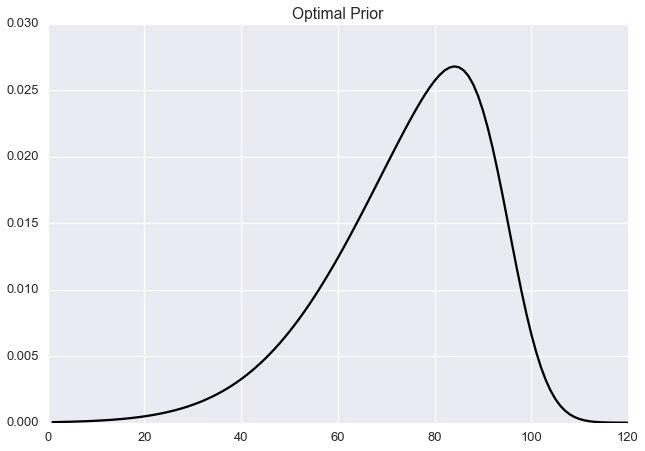

In [25]:
# Prior which is the actual solution and
# is used to generate the observed data 

# prior parameters
skew = -4    # fixed parameter
loc = 95     # to be estimated
scale = 26   # fixed parameter

prior = skew_gauss(skew, loc, scale)
plt.figure()
plt.title("Optimal Prior")
plt.plot(thetas, prior, 'k')

# Note that the mean is about 75 and the std. deviation
# is about 16 as mentioned in the tenenbaum paper.
mean = st.skewnorm.mean(skew, loc, scale)
std_dev = st.skewnorm.std(skew, loc, scale)
print "Mean: ", mean
print "Std. deviation: ", std_dev

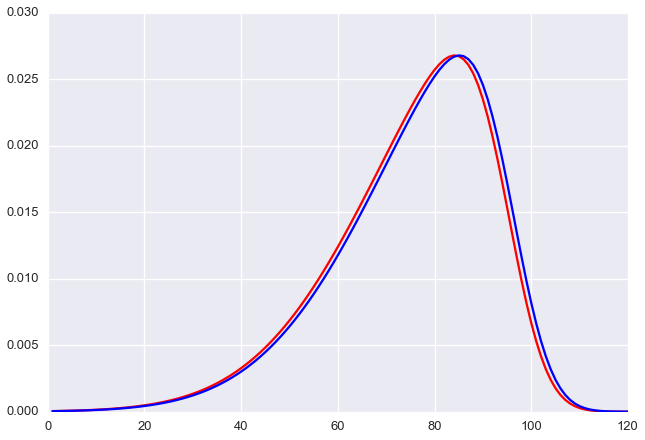

In [33]:
# Showing that the difference between priors with 
# loc = 95 and 96 is not too much and hence the fractional 
# values between any two integer values of loc can be ignored
# to limit the search space and simplify the problem.
plt.figure()
prior = skew_gauss(skew, 95, scale)
plt.plot(thetas, prior, 'r')
prior = skew_gauss(skew, 96, scale)
plt.plot(thetas, prior, 'b')

Mean:  -0.125604788761
Std. deviation:  16.4608636434
Mean:  120.874395211
Std. deviation:  16.4608636434


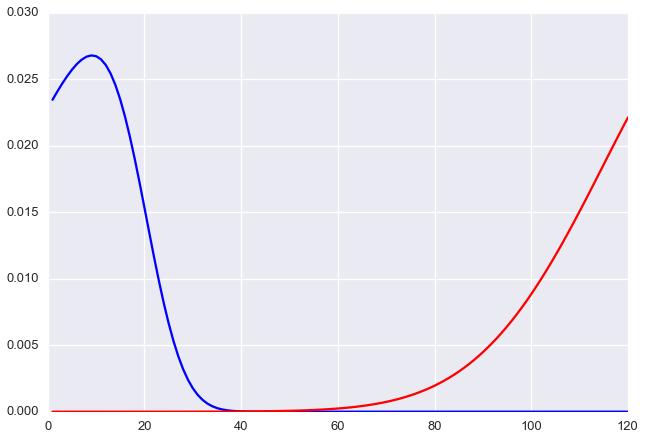

In [5]:
# The Prior is conditioned on three parameters, however
# we assume that two of the parameters are fixed and estimate
# only one parameter 'loc'. Thus the hyperparameter alpha to  
# be is estimated is 'loc' in this case.

# Check the range of values we should be searching over.
# We know that the mean age should be between 0 to 120 since 
# we are assuming max age is 120. Hence, we should search over
# the range of values of 'loc' that give mean between 0 to 120.

# lower bound
loc_r = 20 

prior = skew_gauss(skew, loc_r, scale)
plt.figure()
plt.plot(thetas, prior, 'b')

mean = st.skewnorm.mean(skew, loc_r, scale)
std_dev = st.skewnorm.std(skew, loc_r, scale)
print "Mean: ", mean
print "Std. deviation: ", std_dev

# upper bound
loc_r = 141 

prior = skew_gauss(skew, loc_r, scale)
plt.plot(thetas, prior, 'r')

mean = st.skewnorm.mean(skew, loc_r, scale)
std_dev = st.skewnorm.std(skew, loc_r, scale)
print "Mean: ", mean
print "Std. deviation: ", std_dev

# Thus the search range for 'loc' is 20 to 141 since priors
# beyond these values wouldn't make sense for this problem
# The hypothesis is that people are able to constrain their
# search space based on the knowledge of min and max ages
# they observe in the world around them.

# Thus loc has discrete values from 20 - 141. 
# Remember alpha = loc 
upper = 141 
lower = 20 
alpha = np.arange(lower, upper+1, 1)   # possible values of alpha
M = upper-lower+1  # number of discrete possibilities of alpha

From Aaron's notebook:
The two stage hierarchical bayes model is summarised in the <a href="https://en.wikipedia.org/wiki/Plate_notation">Plate notation</a> as follows:
![](http://i.imgur.com/gmLKIjJ.png)

The data is generated in the forward direction ($\alpha \longrightarrow Z \longrightarrow X$). Then only $X$ is accessible to the model, along with the "knowledge" of how this was generated. The actual parameters for $Z$ and $\alpha$ are hidden from the model. The task is then to infer the most likely $Z$ and $\alpha$ given the observed sample $X$.

In [6]:
# These two functions are used to generate the sample X. 

# Function to sample discrete random values from a skewed gaussian distribution
def randn_skew(n_samples, skew=0.0, loc=0.0, scale=1.0):
    probs = skew_gauss(skew, loc, scale)
    probs /= sum(probs)   # to make sure the sum is exactly 1 and not 0.999
    samples = np.random.choice(thetas, size=n_samples, replace=True, p=probs)   
    samples = list(samples)  #convert ndarray to a python list
    return samples

# Function to draw samples X for the given number of trials
def draw(n_trials, n_samples):
    x_vector = []
    for i in np.arange(n_trials):
        z_vector = randn_skew(n_samples=n_samples, skew=skew, loc=loc, scale=scale)  # generating Z from alpha
        x_vector.append(np.asarray([np.random.randint(low=1, high=th+1) for th in z_vector]))   # X from Z
    return x_vector

In [7]:
# Compute the prior for all values of alpha
# this is our search space
prior = np.zeros((len(alpha), max_age))
i = 0
for k in alpha:
    prior[i, :] =  skew_gauss(skew, alpha[i], scale)    # p(Z)
    prior[i, :] = prior[i, :]/sum(prior[i, :])  # normalize prior 
    i = i+1
    
    
# priors conditioned on alpha: p(Z/A)    
pZA = prior
logpZA = np.log(pZA)    

Following block defines three algorithms: <br>1. Expectation maximization - basic EM algorithm using argmax (not using the closed form). <br>2. Stepwise expectation maximization - Online EM algorithm which recieves one example at a time and the stored terms are updated with each incoming example. <br>3. 
Stepwise EM Iterative - Similar to (2) except that we iterate for a few times as each example comes in. 

In [29]:
from nengo.utils.progress import ProgressTracker

# Function to compute the likelihood of each  
# 'x' in the Sample X (x_vector)
def compute_lik(x_vector):
    lik = np.zeros((len(x_vector), max_age))
    i = 0
    count = 0
    for obs in x_vector:
        if int(obs) > 120:
            obs = 120   
            count = count + 1 
        lik[i,:] = likelihood(obs)    #pXZ
        i = i+1
    #print "Count samples above 120: ", count    
    return lik    
      

# Basic EM algorithm    
# works but only when intial value is in the correct space
# random initialization doesn't work well
def expectation_maximization(x, num_iter=5):
    _pXZ = compute_lik(x)
    a = np.random.randint(90, 100) - lower
    #a = np.random.randint(lower, upper) - lower      
    
    best_a = None
    best_utility = float('-inf')
    for k in range(num_iter):
        L = np.zeros(M)   # number of discrete possibilities for alpha
        for i, p in enumerate(_pXZ):
            pxz = p * pZA[a, :]
            L += (pxz / np.sum(pxz)).dot(logpZA.T)
       
        max_a = np.argmax(L)
        if L[max_a] > best_utility:
            best_a = max_a
            best_utility = L[max_a]
        
        # Keep trying new things anyways, in case we are
        # trapped in a discrete local minima
        L[a] = np.min(L)
        a = np.argmax(L) 
        if a == best_a:  # considered already
            break   
    return best_a + lower   # add one to index



# Online EM where the stored terms are decayed away
# Converges for any random inital value
# As each example comes in, we update the stored terms/iterate
# only once. After all examples are received, we repeat the entire
# process/iterate by reusing the same set of examples 'num_iter' times.
def stepwise_expectation_maximization(x, num_iter=5):
    _pXZ = compute_lik(x)
    a = np.random.randint(lower, upper) - lower 
    #print "start: ", a           
    best_a = None
    best_utility = float('-inf')
    flag = 0
    
    S = np.zeros(M)   # sufficient statistics
    k = 0             # number of updates made to S so far/ minibatch index
    beta = 0.86       
    m = 1             # mini-batch size
    _pXZ_list = list(enumerate(_pXZ))

    for r in range(num_iter):
        np.random.shuffle(_pXZ_list) 
        flag = 0
        for i, p in _pXZ_list:
            if flag%m == 0:
                L = np.zeros(M)   
            pxz = p * pZA[a, :]
            L += (pxz / np.sum(pxz)).dot(logpZA.T)
            flag = flag + 1
            if flag%m != 0:
                continue
        
            gamma = np.power(float(k+2), -beta)  
            k = k + 1
            
            S = gamma*L + (1-gamma)*S
            max_a = a = np.argmax(S)
                   
            #print max_a + lower
    return max_a + lower



# Online EM where the stored terms are decayed away
# Adding iterations for each example (1) similar to STM cycling
# around hippocampus while being consolidated in the LTM.
# 1) Inner terations: As each example comes in, we update the stored 
# terms and  iterate 'num_inner_iter' times for each individual example.
# 2) Outer Iterations: After all examples have been received, we repeat the 
# entire process/iterate by reusing the same set of examples 'num_iter' times.
# This might be similar to refelcting on past experiences etc.
def stepwise_em_iterative(x, num_iter=5, num_inner_iter=5):
    _pXZ = compute_lik(x)
    a =  np.random.randint(lower, upper) - lower 
    #print "start: ", a           
    best_a = None
    best_utility = float('-inf')
    flag = 0
    
    S = np.zeros(M)   # sufficient statistics
    k = 0             # number of updates made to S so far
    beta = 0.86       
    _pXZ_list = list(enumerate(_pXZ))

    for r in range(num_iter):
        np.random.shuffle(_pXZ_list) 
        flag = 0
        for i, p in _pXZ_list:
            for _ in range(num_inner_iter): 
                L = np.zeros(M)   
                pxz = p * pZA[a, :]
                L += (pxz / np.sum(pxz)).dot(logpZA.T)

                gamma = np.power(float(k+2), -beta)  
                k = k + 1

                S = gamma*L + (1-gamma)*S
                max_a = a = np.argmax(S)

                #print max_a + lower
    return max_a + lower



def grade_solution(f, n_trials, n_samples, name=None, plot=True):
    X = draw(n_trials, n_samples)
    
    correct = 0
    diff = np.empty(n_trials)
    with ProgressTracker(1, True, "Initializing"): pass  # Hack to fix bug
    with ProgressTracker(n_trials, True, name) as progress:
        for j in range(n_trials):
            #print "X, alpha: ", X[j], alpha[j]
            a_est = f(X[j])
            if a_est == loc:
                correct += 1
            diff[j] = a_est-loc #np.abs(a_est-loc)
            progress.step()
    acc = correct / float(n_trials)
    #print ("%s (Accuracy = %.3f)" % (name, acc))
    
    if plot:
        plt.figure()
        plt.title("%s (Accuracy = %.3f)" % (name, acc), fontsize=18)
        plt.plot(diff, 'o')
        sns.set_style('darkgrid')
        plt.xlabel("number of trials", fontsize=18)
        plt.ylabel("Diff. between estimate and ideal alpha", fontsize=18)
        sns.despine(offset=10)
        plt.show()
    return acc

There are two ways of evaluating these different algorithms. One is accuracy i.e., number of times the algorithm converges to the optimal value which is 95. Second, how close the convergence values are to the optimal value. I think its reasonable if the algorithm converges to values close to the optimal value, since they will lead to priors which are close, and hence can lead to similar samples $X$.

Basic EM with random initial value. It keeps getting stuck in the nearest local minima if the initial value is not from a constrained space near the optimal value.

Initializing finished in 0:00:01.                                               
Expectation Maximization finished in 0:00:27.                                   


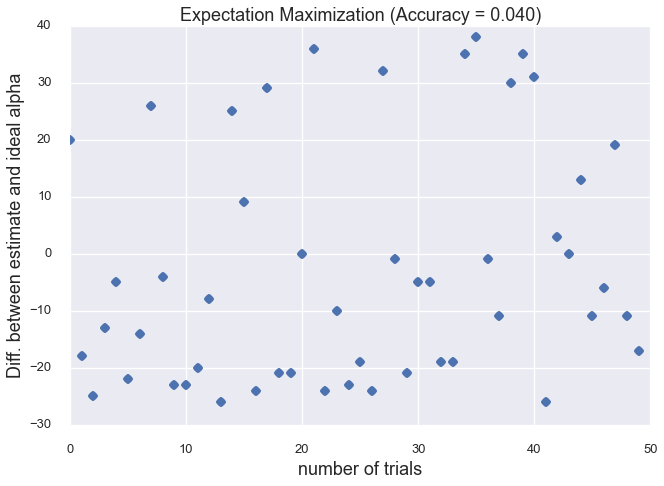

0.04

In [11]:
grade_solution(expectation_maximization, n_trials=50, n_samples=5000, name="Expectation Maximization")

Basic EM with initial value from a highly constrained space (90-100). In this case, it mostly converges to values near the optimal value.

Initializing finished in 0:00:01.                                               
Expectation Maximization finished in 0:00:38.                                   


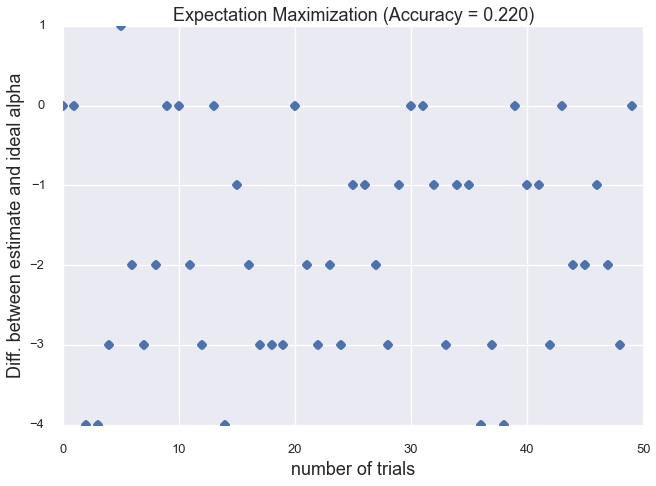

0.22

In [23]:
grade_solution(expectation_maximization, n_trials=50, n_samples=5000, name="Expectation Maximization")

Five iterations of stepwise EM with random initial value:

Initializing finished in 0:00:01.                                               
Stepwise Expectation Maximization finished in 0:00:55.                          


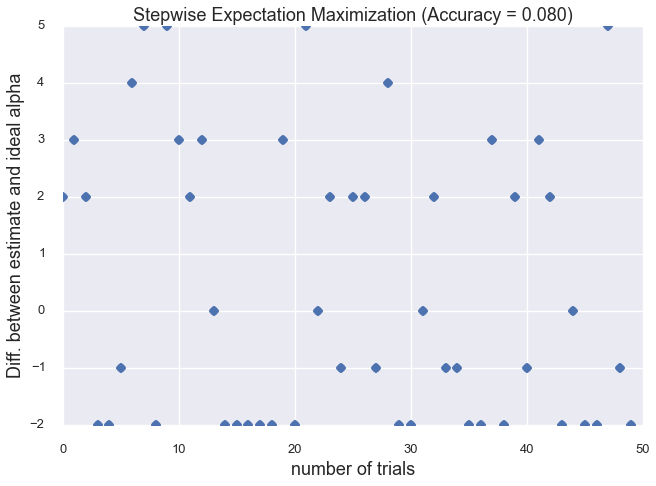

0.08

In [14]:
grade_solution(stepwise_expectation_maximization, n_trials=50, n_samples=5000, name="Stepwise Expectation Maximization")

Stepwise Iterative EM with num_iter=5 and num_inner_iter=5. This does better than the above case where there were no inner iterations (in terms of how close the convergence value is to the optimal value). Thus, adding inner iterations seems to add some value.

Initializing finished in 0:00:01.                                               
Stepwise Iterative EM finished in 0:03:10.                                      


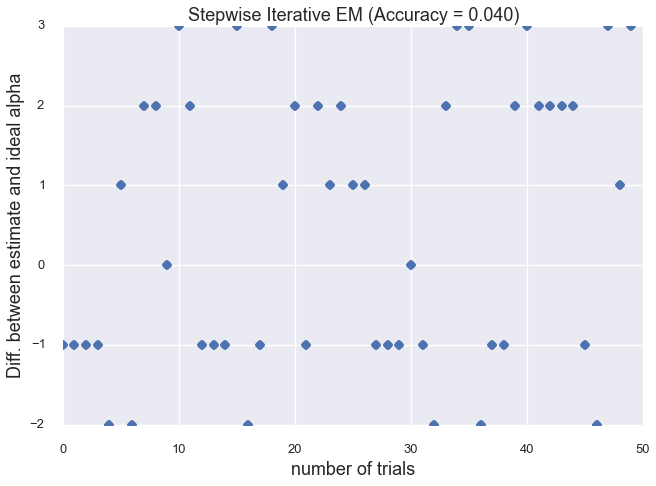

0.04

In [15]:
grade_solution(stepwise_em_iterative, n_trials=50, n_samples=5000, name="Stepwise Iterative EM")

Stepwise Iterative EM with num_iter=5 and num_inner_iter=10 iterations. Further increasing number of inner iterations doesn't provide much advantage given there are 5 outer iterations. It might help if the outer iterations are lesser.

Initializing finished in 0:00:01.                                               
Stepwise Iterative EM finished in 0:07:15.                                      


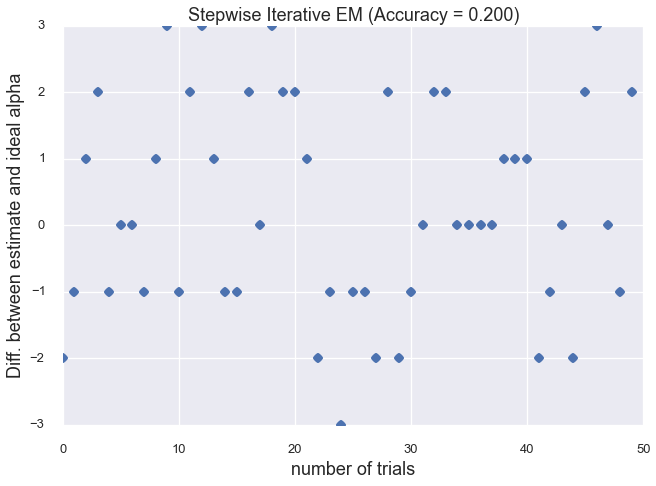

0.2

In [22]:
grade_solution(stepwise_em_iterative, n_trials=50, n_samples=5000, name="Stepwise Iterative EM")

Stepwise Iterative EM with num_iter=1 and num_inner_iter=5 iterations. Reducing the number of outer iterations performs worse than the case where num_iter=5 (given num_inner_iter=5). Thus outer iterations also add value.

Initializing finished in 0:00:01.                                               
Stepwise Iterative EM finished in 0:00:53.                                      


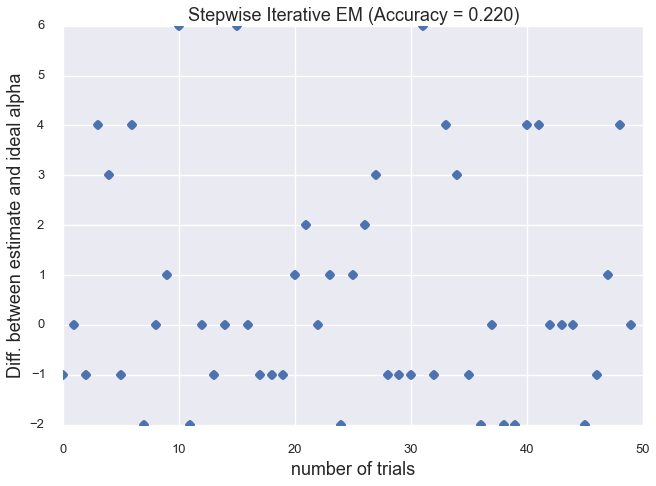

0.22

In [18]:
grade_solution(stepwise_em_iterative, n_trials=50, n_samples=5000, name="Stepwise Iterative EM")

In all the above cases, we see that accuracy (i.e., number of times convergence value = optimal value) is very low. However, most of the convergence values from Stepwise Iterative EM lie within +/-3 of the optimal value if we chose the right number of iterations. In other words, this algortihm is converging to a set of priors close to the optimal prior as shown below. This might be okay since different individuals might have different priors. Moreover, even for the same individual, the priors might oscillate in a small range based on the examples received from daily experience. 

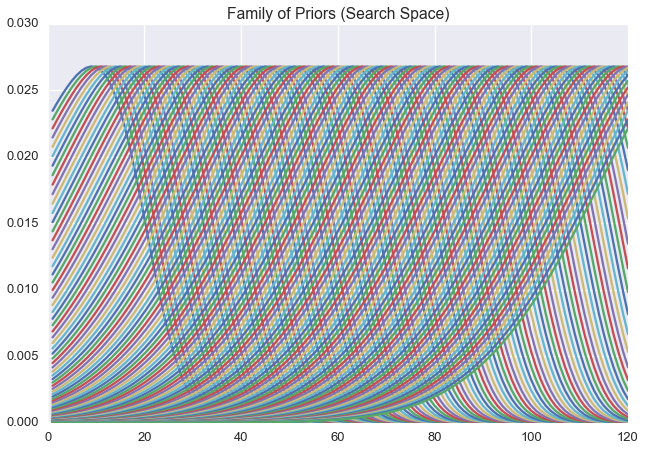

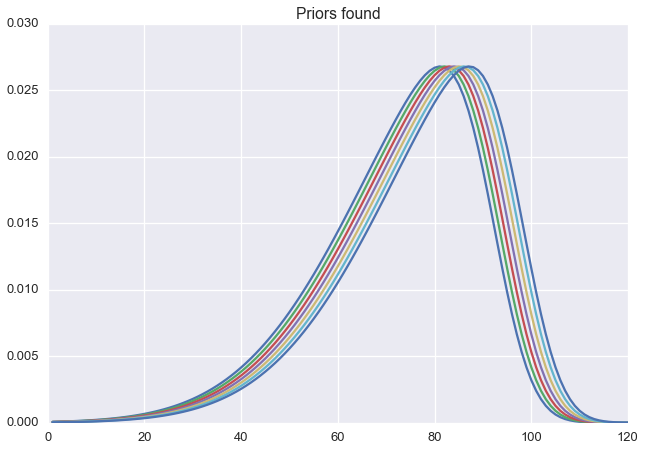

In [48]:
# Plot the search space - priors we are searching over
plt.figure()
plt.title("Family of Priors (Search Space)")
for loc_value in alpha:
    prior = skew_gauss(skew, loc_value, scale)
    plt.plot(thetas, prior)
    

# Plot the priors with value of loc within +/-3 of 95
plt.figure()
plt.title("Priors found")    
loc_list = [loc-3, loc-2, loc-1, loc, loc+1, loc+2, loc+3]
for loc_value in loc_list:
    prior = skew_gauss(skew, loc_value, scale)
    plt.plot(thetas, prior)

### Issues of Scalability

<p>1. What if we add k extra variables to our inference problem. Say the observation that a person has cancer, or eats broccoli etc. How would the size of our network and the performance scale with increasing k?</p>
<p> 
Note that in our model:
<li> Likelihood function corresponds to the sensory information </li>
<li> Prior corresponds to the prior information one has from previous experience </li>

<br>So in this case, the observations related to disease, diet etc. will modify the likelihood function. The likelihood distribution will still have the same number of dimensions, but the distribution itself will change. Thus, it shouldn't really effect performance. The challenge would be to come up with a likelihood function that encapsulates all k variables. Shouldn't make any difference from the point of view of representation and scalability. 
</p>


<p>2. How does it scale with the number of unknown hyperparameters?
<br>If we have 'n' unknown hyperparameters, our search space would be product of size(search_space) of each hyperparameter. As long as we discretize the search space for all hyperparameters, the search space would still be finite, however, it won't scale very well to large n. Also I don't think the priors in our brains would be conditioned on a large number of hyperparameters either. 
<br>However, the fact is that it scales exponentially with the number of hyperparameters. The size of search space for our unknown hyperparameter in the above problem is 122. Assuming the search space for other two parameters is also the same size, our search space would consist of 122^3 = 1,815,848 possible priors.
</p>